# `hw4`: Historical CO2 and temperature data

In [1]:
# Fill in this cell with your personal details:
# - Name: Mvomo Eto Wilfried 
# - Student ID: s226625
# - Email: Wilfried.MvomoEto@student.uliege.behttp://localhost:8888/notebooks/hh.ipynb#hw4:-Historical-CO2-and-temperature-data

Deadline: **Friday, December 22, 23:59**.

Instructions:
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- This case study must be carried out alone. You are not allowed to discuss or collaborate with other students.
- In January, you will have to explain and defend your solution during a 30-minute oral exam.
- The take-home exam (including its defense in January) will account for 50% of the final grade.

Comments:
- Solve the case study below by following the Bayesian workflow as best as possible.
- Follow the data visualization principles to make your plots effective and readable.
- Make the best use of the Python scientific ecosystem.
- Feel free to add comments when necessary.

# Introduction

Analyses of ice cores from the Vostok station in East Antarctica have shown that the concentration of CO2 in the atmosphere and the temperature at the surface of the Earth are correlated (Petit et al, 1999). The goal of this case study is to analyze these two time series and quantify their relationship.

The data provided for this case study include 200 values of temperature measured at roughly equally spaced time intervals, with time between consecutive measurements being approximately 2000 years. For each value of temperature, the dataset also includes the  value of CO2 concentration corresponding to a date that is roughly 1000 years previous to the date of the temperature measurement. Temperatures are given in terms of its deviation from the average current temperature and CO2 concentrations are given in parts per million by volume (ppm).

![](drilling.jpg)


# Data exploration

<div class="alert alert-success">
    
**Q1**. Load the `icecore.csv` dataset into a data frame.
    
</div>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import describe, mode
from sklearn.metrics import mean_squared_error
from scipy.stats import norm, gamma, multivariate_normal, uniform, beta

import emcee
import corner
from scipy.optimize import minimize
from scipy.linalg import eigh
from IPython.display import Image, display
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [3]:
data = pd.read_csv(r'./icecore.csv')

In [4]:
print(data.info())
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   year        200 non-null    float64
 2   co2         200 non-null    float64
 3   tmp         200 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 6.4 KB
None


,Unnamed: 0,year,co2,tmp
0,0,-419095.0,277.6,0.94
1,1,-416872.0,286.9,1.36
2,2,-414692.0,285.5,1.07


<div class="alert alert-success">
    
**Q2**. Explore the dataset and report relevant insights.

</div>

The statistical formula : a = cov($CO_2$, $tmp$) / var($CO_2$), helps us to get the blue regression 
line in the scatter plot and whose the corresponding equation is : $ y = ax + b $ where $a = 0.08$ and $b = -23.16$. Noting that the mean point belongs to this regression line.

beta_1 = 0.08025417615215187 via statistic formula.
beta_0 = -23.115499174176946
Covariance: 64.1555533919598
Correlation Matrix:
           co2       tmp
co2  1.000000  0.828634
tmp  0.828634  1.000000


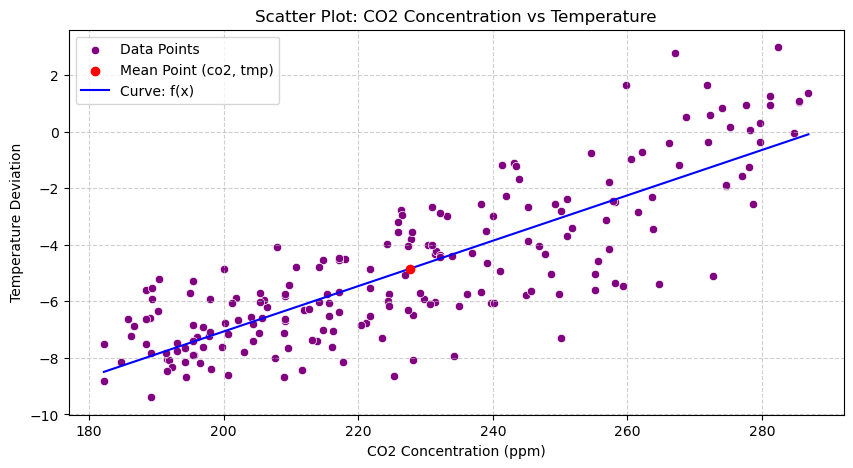

In [5]:
# Calculate correlation coefficient
covariance_matrix = np.cov(data['co2'], data['tmp'])
covariance_co2_tmp = covariance_matrix[0, 1]  # Covariance between 'co2' and 'tmp'
variance_co2 = np.var(data['co2'])  # Variance of 'co2'

correlation_coefficient = covariance_co2_tmp / variance_co2

# Print the correlation coefficient
print("beta_1 =", correlation_coefficient, "via statistic formula.")
print("beta_0 =", -correlation_coefficient * data['co2'].mean() + data['tmp'].mean())

# Print covariance
print("Covariance:", covariance_co2_tmp)

# Calculate the correlation matrix
correlation_matrix = data[['co2', 'tmp']].corr()
print("Correlation Matrix:\n", correlation_matrix)

# Plot the scatter plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x='co2', y='tmp', data=data, color='purple', label='Data Points')

# Plot the point (data['co2'].mean(), data['tmp'].mean()) in red
plt.scatter(data['co2'].mean(), data['tmp'].mean(), color='red', label='Mean Point (co2, tmp)', zorder=5)

# Generate x values
x_values = np.linspace(data['co2'].min(), data['co2'].max(), 100)

# Calculate corresponding y values using the specified function
y_values = correlation_coefficient * x_values + (-correlation_coefficient * data['co2'].mean() + data['tmp'].mean())

# Plot the curve
plt.plot(x_values, y_values, color='blue', label='Curve: f(x)')

# Show the grid
plt.grid(True, linestyle='--', alpha=0.6)

# Show the legend
plt.legend()

# Add titles and labels
plt.title('Scatter Plot: CO2 Concentration vs Temperature')
plt.xlabel('CO2 Concentration (ppm)')
plt.ylabel('Temperature Deviation')

# Show the plot
plt.show()

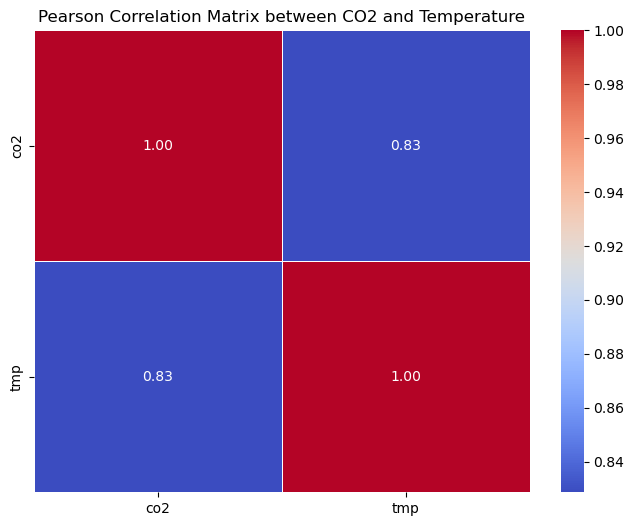

In [6]:
# Compute correlation matrix
correlation_matrix = data[['co2', 'tmp']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Matrix between CO2 and Temperature')
plt.show()

The both variables (temperature and $CO_2$) are strongly correlated. we can observe that through the Pearson correlation matrix above.

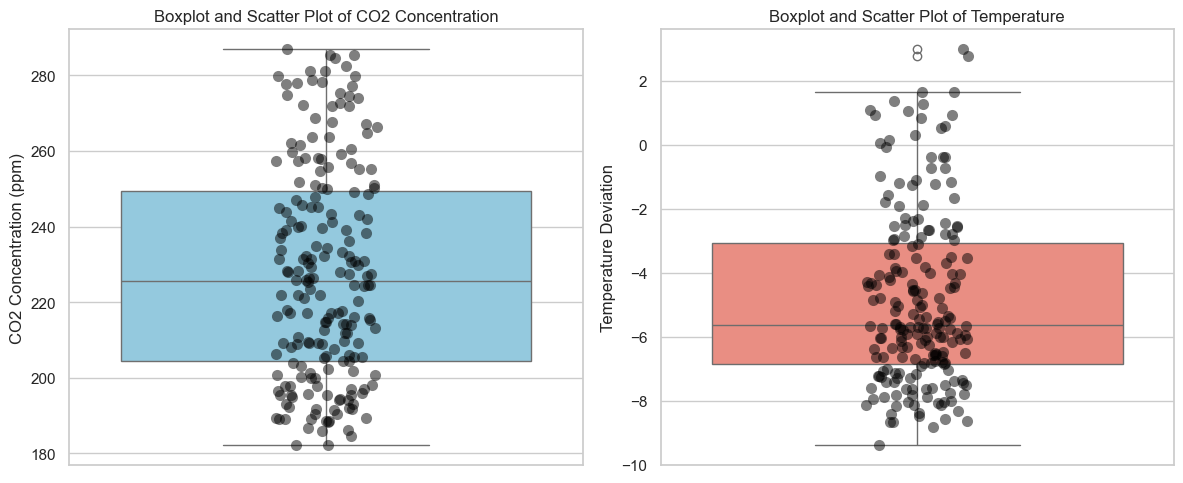

In [7]:
sns.set(style="whitegrid")

# Create a mix of boxplot and scatter plot for CO2 concentration and temperature
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Boxplot for CO2 concentration
sns.boxplot(y='co2', data=data, color='skyblue', ax=axes[0])
sns.stripplot(y='co2', data=data, color='black', size=8, jitter=True, alpha=0.5, ax=axes[0])
axes[0].set_title('Boxplot and Scatter Plot of CO2 Concentration')
axes[0].set_ylabel('CO2 Concentration (ppm)')

# Boxplot for temperature
sns.boxplot(y='tmp', data=data, color='salmon', ax=axes[1])
sns.stripplot(y='tmp', data=data, color='black', size=8, jitter=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Boxplot and Scatter Plot of Temperature')
axes[1].set_ylabel('Temperature Deviation')

plt.tight_layout()
plt.show()

There are some outlying observations in the Temperature variables. Indeed their values are larger than the upper (extreme) bar of the Temperature's box plot. We must drop their corresponding rows in the data frame.

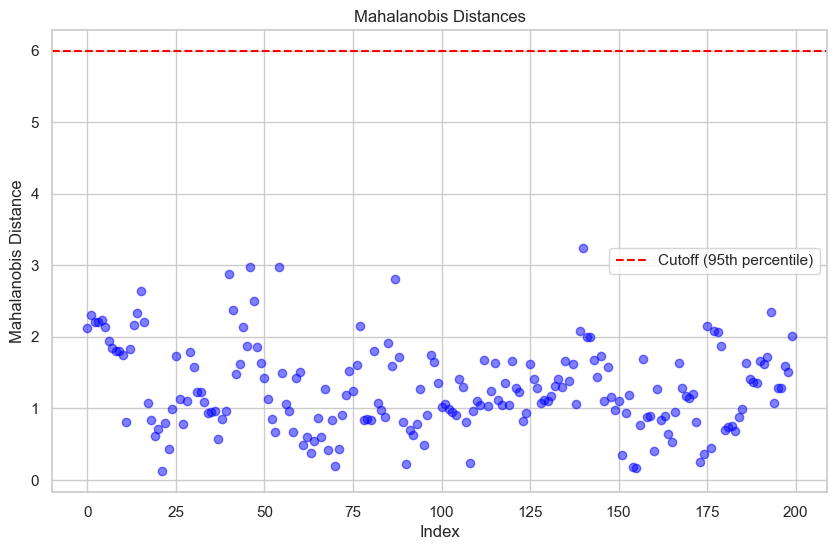

In [8]:
from scipy.spatial import distance
from scipy.stats import chi2

# Calculate the number of variables
num_variables = 2

# Calculate the quantile corresponding to the 95th percentile of the chi-square distribution
quantile = chi2.ppf(0.95, num_variables)

# Calculate the mean vector
mean_vector = data[['co2', 'tmp']].mean()

# Calculate the covariance matrix
cov_matrix = data[['co2', 'tmp']].cov()

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate Mahalanobis distance for each data point
mahalanobis_distances = []
for index, row in data.iterrows():
    data_point = row[['co2', 'tmp']]
    mahalanobis_distance = distance.mahalanobis(data_point, mean_vector, inv_cov_matrix)
    mahalanobis_distances.append(mahalanobis_distance)

# Add the Mahalanobis distances as a new column to your DataFrame
data['mahalanobis_distance'] = mahalanobis_distances

# Plot cleaned data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['mahalanobis_distance'], marker='o', linestyle='', color='blue', alpha=0.5)
plt.axhline(y=quantile, color='red', linestyle='--', label='Cutoff (95th percentile)')
plt.title('Mahalanobis Distances')
plt.xlabel('Index')
plt.ylabel('Mahalanobis Distance')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Determine observations above cutoff
above_cutoff = data[data['mahalanobis_distance'] > quantile]
num_above_cutoff = len(above_cutoff)
print("Number of observations above cutoff:", num_above_cutoff)

# Delete observations above cutoff
data = data[data['mahalanobis_distance'] <= quantile]

Number of observations above cutoff: 0


No outlying obseravtion in the data set.

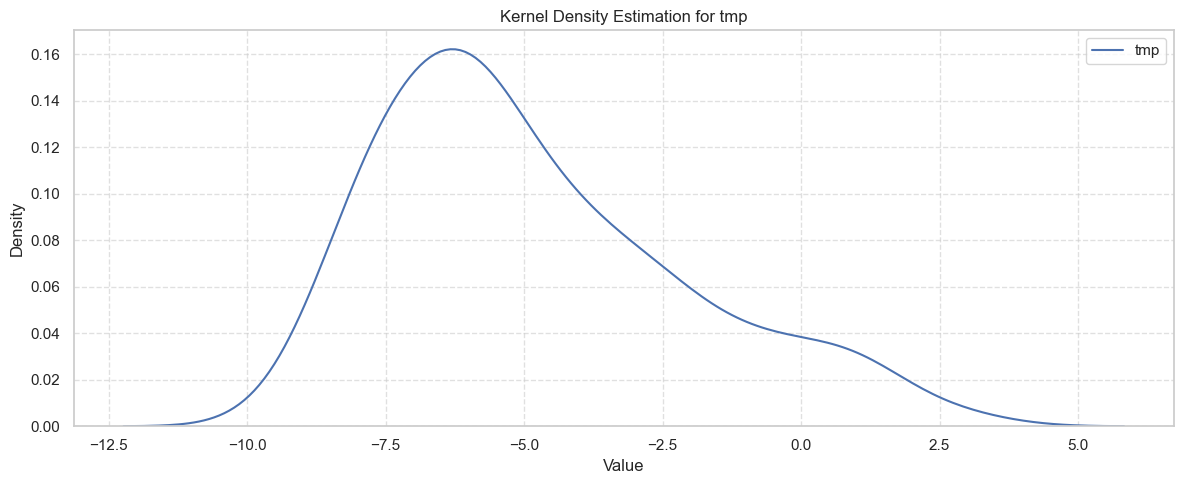

In [10]:
# Plotting a single kernel density plot
plt.figure(figsize=(12, 5))
sns.kdeplot(data['tmp'], label='tmp')

plt.title(f'Kernel Density Estimation for tmp')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
columns = ['tmp']
# Compute kurtosis and skewness for 'co2' and 'tmp'
kurtosis_values = data[columns].apply(kurtosis)
skewness_values = data[columns].apply(skew)

# Print the results
for column in columns:
    print(f"{column} Kurtosis: {kurtosis_values[column]:.2f}")
    print(f"{column} Skewness: {skewness_values[column]:.2f}")
    print("------------------------")

tmp Kurtosis: -0.09
tmp Skewness: 0.80
------------------------


The $CO_2$ variable mode is around on 205 while the one of Temperature variable is around -7.6. Under normal distribution, a skewness is 0 and a kurtosis is 3. However, the different kurtosis and skewness values of the $CO_2$ and Temperature features are obviously different to 3 and 0 respectively, meaning that their distributions are not Gaussian.

# Build: Probabilistic modelling

Our goal is to assess the correlation between CO2 concentration and temperature. In statistical terms, we will make this assessment through a linear regression model. Denoting by $\mathbf{x} = (x_1, \ldots, x_N)$ the CO2 concentration measurements and by $\mathbf{y} = (y_1, \ldots, y_N)$ the temperature measurements, we will consider two variations of the linear regression model:

- **Model 1**. The temperature is a linear function of CO2 concentration with additive uncorrelated Gaussian noise: $p(\mathbf{y} \mid \mathbf{x}, \theta) = \mathcal{N}(\mathbf{y} \mid \beta_0 + \beta_1 \mathbf{x}, \sigma^2 \mathbf{I})$.
- **Model 2**. The temperature is a linear function of CO2 concentration with additive correlated Gaussian noise: $p(\mathbf{y} \mid \mathbf{x}, \theta) = \mathcal{N}(\mathbf{y} \mid \beta_0 + \beta_1 \mathbf{x}, \sigma^2 \mathbf{C}_\rho)$, where $\mathbf{C}_\rho = [\rho^{|i - j|}]_{i,j=1}^N$ is a first-order autoregressive correlation matrix with parameter $\rho$. The $i$ and $j$ indexes denote the positions of the entries in the dataset (ordered by time).

Parameters $\beta_0$, $\beta_1$, $\sigma^2$ and $\rho$ are unknown and must be estimated from the data. They will come with their own prior distributions.

<div class="alert alert-success">
    
**Q3**. Draw the probabilistic graphical models associated with the two models above.
    
</div>

For the model 1: $\theta = (\beta_0, \beta_1, \sigma^2)$.

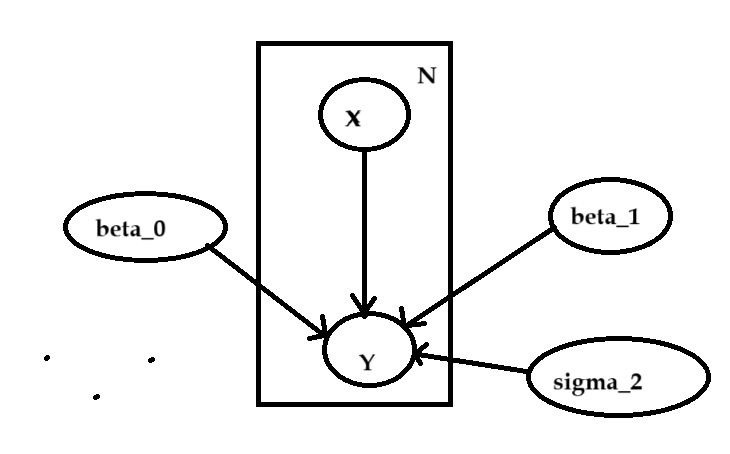

In [10]:
display(Image(filename=r'./model1.png'))

For the model 2:  $\theta = (\beta_0, \beta_1, \sigma^2,\rho)$.

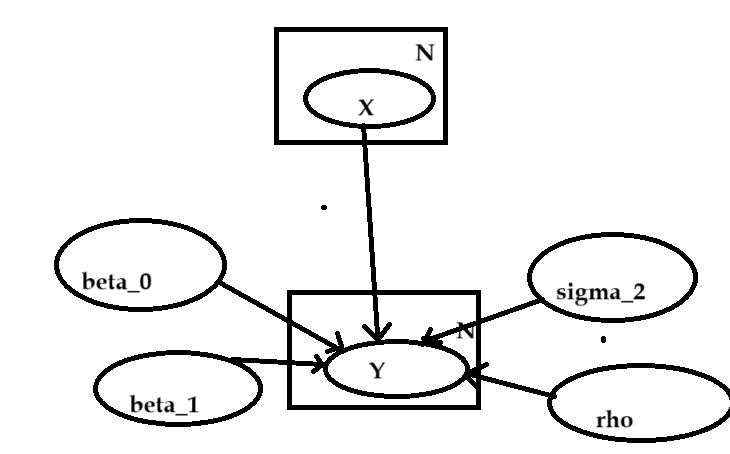

In [11]:
display(Image(filename=r'./model2.png'))

<div class="alert alert-success">
    
**Q4**. Implement the models defined above. For the time being, consider an uninformative prior for the model parameters.
    
</div>

In this step, we use uniform distrinution as an uniformative prior distribution for the model parameters.

In [22]:
# Implementing model 1: theta[0] = beta_0, theta[1] = beta_1, theta[2] = sigma_2
def simulate_mod1(x, theta):
    n = len(x)
    mu = theta[0] + theta[1] * x
    sigma_2 = theta[2]   # Covariance matrix is sigma^2 * identity matrix
    noise = multivariate_normal(mean=np.zeros(n), cov=sigma_2 * np.eye(n)).rvs()
    y = mu + noise

    return y

In [15]:
# 𝑃((x,𝑦)|𝛽0,𝛽1,𝜎2)
# Simulate samples from the uninformative prior distributions
def simulateMod1(x, num):
    # Simulate samples from the uniform distributions
    sigma_2_prior = uniform(loc=data['tmp'].var(), scale=1).rvs(num)
    beta_0_prior = uniform(loc=-5, scale=1e-1).rvs(num)
    beta_1_prior = beta(0.01, 1).rvs(num)

    # Simulate temperature samples
    tmp_samples = []
    realized_params = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_prior[i], beta_1_prior[i], sigma_2_prior[i]]

        # Simulate temperature samples using the provided simulation function
        tmp_sample_i = simulate_mod1(x, theta_i)

        tmp_samples.append(tmp_sample_i)
        realized_params.append({'beta_0': theta_i[0], 'beta_1': theta_i[1], 'sigma_2': theta_i[2]})

    return {'tmp_samples': np.array(tmp_samples), 'realized_params': realized_params}

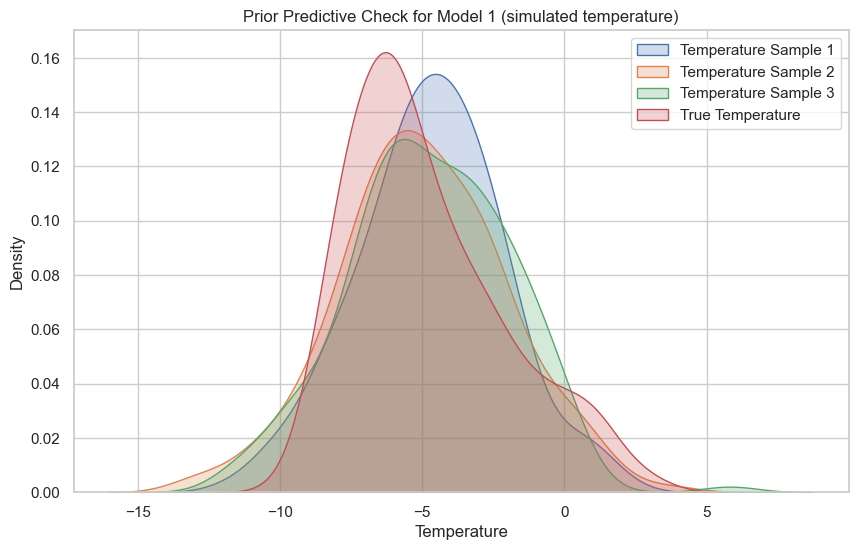

In [16]:
np.random.seed(1)
# Simulating
simulation_result2 = simulateMod1(data['co2'], num=3)

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i,tmp_sample_i in enumerate(simulation_result2['tmp_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Prior Predictive Check for Model 1 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

In [23]:
# Implementing model 2: theta[0] = beta_0, theta[1] = beta_1, theta[2] = sigma_2, theta[3] = rho
def simulate_mod2(x, theta):
    n = len(x)
    mu = theta[0] + theta[1] * x
    sigma_2 = theta[2]
    rho = theta[3]

    # Generate correlated Gaussian noise
    cov_matrix = np.array([[rho**abs(i - j) if i != j else 1 for i in range(n)] for j in range(n)])
    noise = multivariate_normal(mean=np.zeros(n), cov=sigma_2 * cov_matrix).rvs()

    # Simulated temperature
    y = mu + noise

    # Check and print a warning if rho is outside the range ]-1, 1[
    if not (-1 < rho < 1):
        print("Warning: rho value is outside the range ]-1, 1[.")
    
    return y

In [18]:
# 𝑃((x,𝑦)|𝛽0,𝛽1,𝜎2,rho)
def simulateMod2(x, num):
    # Simulate samples from the uniform distributions
    sigma_2_prior = uniform(loc=data['tmp'].var(), scale=1).rvs(num)
    beta_0_prior = uniform(loc=-5, scale=1e-1).rvs(num)
    beta_1_prior = beta(0.01, 1).rvs(num)
    rho_prior = uniform(loc=-1, scale=2).rvs(num)  

    # Simulate temperature samples
    y_samples = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_prior[i], beta_1_prior[i], sigma_2_prior[i], rho_prior[i]]

        # Simulate temperature samples using the provided simulation function
        y_sample_i = simulate_mod2(x, theta_i)

        y_samples.append(y_sample_i)
    return {'y_samples': np.array(y_samples)}

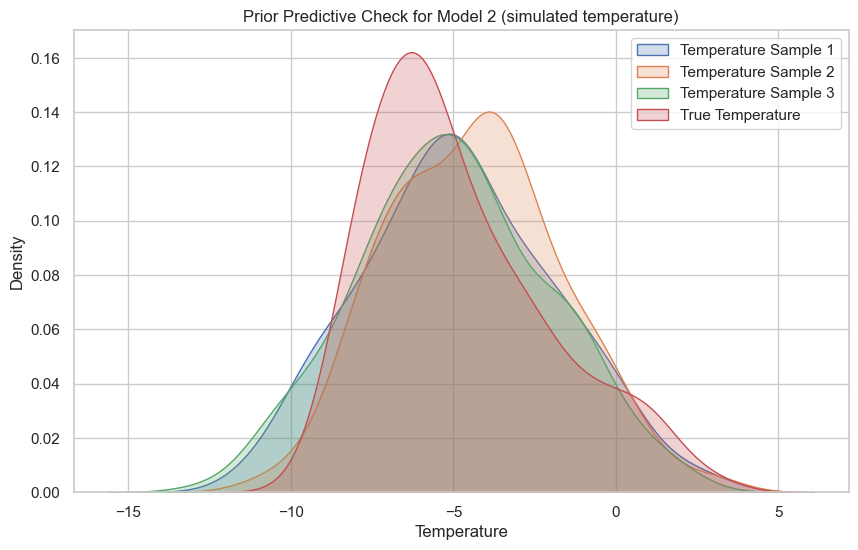

In [19]:
# np.random.seed(6)
# Simulate
simulation_result2 = simulateMod2(data['co2'], num=3)

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i,tmp_sample_i in enumerate(simulation_result2['y_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Prior Predictive Check for Model 2 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

<div class="alert alert-success">
    
**Q5**. Using a prior predictive check, evaluate and discuss if the prior predictive distribution is realistic. Propose a weakly informative prior that results in more realistic simulated data.
    
</div>

Prior choices:

The choice of $\sigma^2$ has been oriented towards the gamma distribution since it is positive.
Regarding $\beta_0$ and $\beta_1$ we chose the normal distribution as their values are set in $\mathbb{R}$. And finally, the parameter $\rho$  is oriented towards the  uniform law [-0.99,0.99] because $\rho$ represents the correlation value, and hence $\rho \in ]-1,1[$.
The initial choice of  $\sigma^2$ is done as follows:  $\hat{\sigma}^2 = \frac{1}{n-1} \sum_{i=1}^{n} (y_i - \bar{y})^2$

With the model 1 : 

Let's start by defining the full joint probability distribution: 

$P((x,y), \beta_0,\beta_1, \sigma^2) = P(\beta_0) \cdot P(\beta_1) \cdot P(\sigma^2) \cdot P(( x,y)|\beta_0,\beta_1, \sigma^2)$

$P((x,y), \beta_0,\beta_1, \sigma^2) = P(\beta_0) \cdot P(\beta_1) \cdot P(\sigma^2)\cdot {\prod_{i=1}^{N} p((x_i,y_i)|,\beta_0,\beta_1, \sigma^2 )}$

In [20]:
# Prior predictive check for model 1
#  𝑃(𝑦,𝛽0,𝛽1,𝜎2|𝑥)
def simulate_joint_mod1(x, num):
    # Simulate samples from the prior distributions
    sigma_2_prior = gamma(1, scale=data['tmp'].var()/3).rvs(num)
    beta_0_prior = norm(loc=-23, scale=1).rvs(num)
    beta_1_prior = norm(loc=0.08, scale=1e-3).rvs(num)

    # Simulate temperature samples
    tmp_samples = []
    realized_params = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_prior[i], beta_1_prior[i], sigma_2_prior[i]]

        # Simulate temperature samples using the provided simulation function
        tmp_sample_i = simulate_mod1(x, theta_i)

        tmp_samples.append(tmp_sample_i)
        realized_params.append({'beta_0': theta_i[0], 'beta_1': theta_i[1], 'sigma_2': theta_i[2]})

    return {'tmp_samples': np.array(tmp_samples), 'realized_params': realized_params}

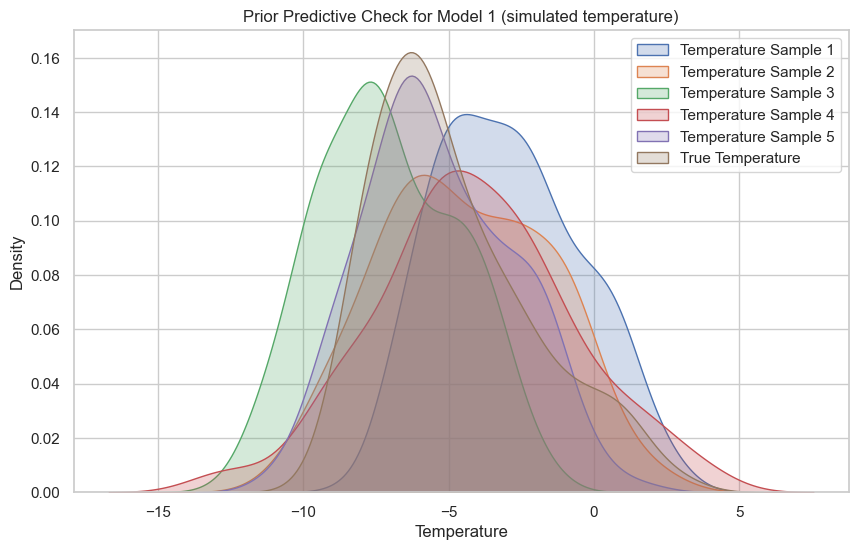

In [21]:
# Simulate
np.random.seed(5)
simulation_result = simulate_joint_mod1(data['co2'], num=5)

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i,tmp_sample_i in enumerate(simulation_result['tmp_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Prior Predictive Check for Model 1 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

In [22]:
# Determining relevant statistics of the simulated temperature and comparing them 
# to those of the true observed temperature
simulated_data_n1 = simulation_result['tmp_samples'][0]
simulated_data_n2 = simulation_result['tmp_samples'][1]
simulated_data_n3 = simulation_result['tmp_samples'][2]
true_data_tmp = data['tmp']

simulated_data_list = [simulated_data_n1, simulated_data_n2,simulated_data_n3, true_data_tmp]

# List to store results
results = []

# Loop over each set of simulated data
for i, simulated_data in enumerate(simulated_data_list, start=1):
    mean_i = np.mean(simulated_data)
    mode_i = mode(simulated_data, axis=None).mode[0]
    skewness_i = skew(simulated_data)
    std_i = np.std(simulated_data)
    kurtosis_i = kurtosis(simulated_data)

    # Append results to the list
    results.append({
        'n': i,
        'mean': mean_i,
        'mode': mode_i,
        'skewness': skewness_i,
        'std': std_i,
        'kurtosis': kurtosis_i
    })

# Print results
for result in results:
    print(f"\nStats for n={result['n']} samples:")
    print(f"Mean: {result['mean']}, Mode: {result['mode']}, Skewness: {result['skewness']}, Std: {result['std']}, Kurtosis: {result['kurtosis']}")


Stats for n=1 samples:
Mean: -2.94259353947323, Mode: -8.193150786862205, Skewness: 0.2613728060289234, Std: 2.4504884568262386, Kurtosis: -0.7648481971625607

Stats for n=2 samples:
Mean: -4.473476392436214, Mode: -11.04415004798296, Skewness: 0.062431822826892115, Std: 2.920860895649856, Kurtosis: -0.7467401523296342

Stats for n=3 samples:
Mean: -7.098107310538093, Mode: -12.477353010625727, Skewness: 0.14860965295312487, Std: 2.412679215392123, Kurtosis: -0.766284686303377

Stats for n=4 samples:
Mean: -4.84375, Mode: -5.74, Skewness: 0.8013453272799188, Std: 2.7246538197539887, Kurtosis: -0.08670314264966805


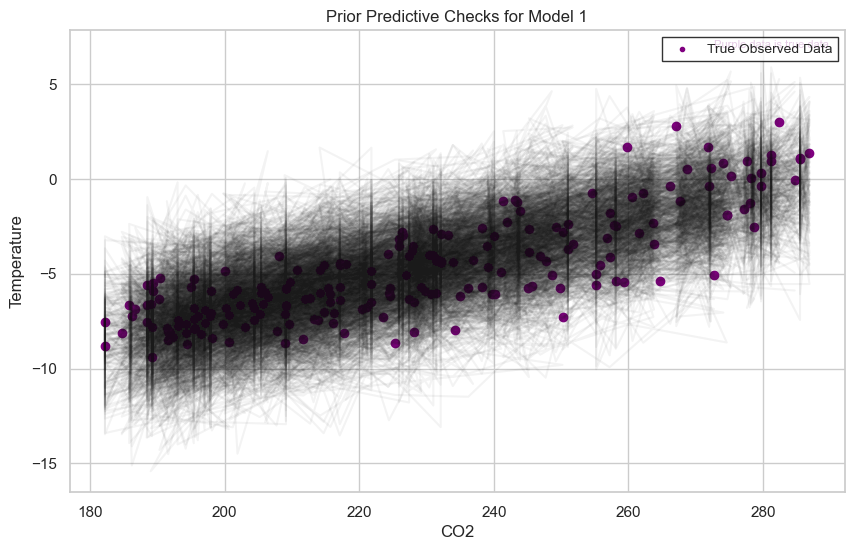

In [23]:
# Observed data
x_obs = data['co2']
y_obs = data['tmp']

# Prior predictive checks
num_samples = 100
beta_0_prior = norm(loc=-23, scale=1).rvs(num_samples)
beta_1_prior = norm(loc=0.08, scale=1e-3).rvs(num_samples)
sigma_2_prior = gamma(1, data['tmp'].var()/3).rvs(num_samples)

# Generate sample using the prior
y_prior = []
for i in range(num_samples):
    theta = [beta_0_prior[i], beta_1_prior[i], sigma_2_prior[i]]
    y_prior.append(simulate_mod1(x_obs, theta))

# Plot le prior prédictive checks
plt.figure(figsize=(10, 6))
for yp in y_prior:
    plt.plot(x_obs, yp, color='k', alpha=0.05) # Prior predictive checks
plt.scatter(x_obs, y_obs, color='purple', label='True Observed Data')  # True observed data
plt.title('Prior Predictive Checks for Model 1')
plt.xlabel('CO2')
plt.ylabel('Temperature')
plt.legend(loc='upper right', fontsize='small', markerscale=0.5, frameon=True, edgecolor='black', fancybox=False)
plt.annotate('Purple data is true data', xy=(0.98, 0.98), xycoords='axes fraction', ha='right', va='top', fontsize=8, color='purple')
plt.show()

In [24]:
def simulate_joint_mod2(x, num):
    # Simulate samples from the prior distributions
    beta_0_prior = norm(loc=-23, scale=1).rvs(num)
    beta_1_prior = norm(loc=0.08, scale=1e-3).rvs(num)
    sigma_2_prior = gamma(1, data['tmp'].var()/5).rvs(num)

    # Simulate rho from the uniform distribution U(]-0.99, 0.99[)
    rho_prior = beta(a=0.1, b=1).rvs(num)
    # Simulate temperature samples and calculate joint probability
    tmp_samples = []
    realized_params = []

    for i in range(num):
        beta_0 = beta_0_prior[i]
        beta_1 = beta_1_prior[i]
        sigma_2 = sigma_2_prior[i]
        rho_values = rho_prior[i]

        # Simulate temperature samples using the adjusted simulation function (simulate_mod2)
        theta_i = [beta_0, beta_1, sigma_2, rho_values]
        tmp_sample_i = simulate_mod2(x, theta_i)

        tmp_samples.append(tmp_sample_i)
        realized_params.append({'beta_0': beta_0, 'beta_1': beta_1, 'sigma_2': sigma_2})

    return {'tmp_samples': np.array(tmp_samples), 'realized_params': realized_params}

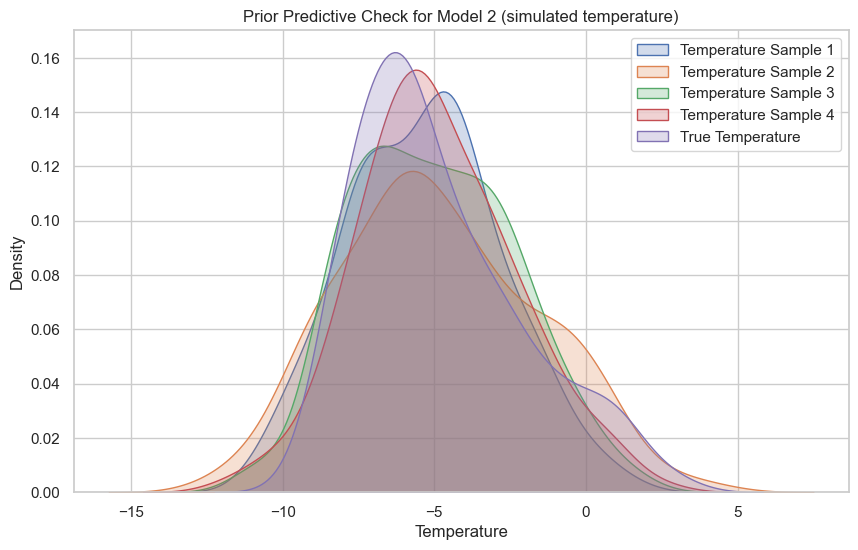

In [25]:
# Simulate
# np.random.seed(0)
simulation_result2 = simulate_joint_mod2(data['co2'], num=4)

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i,tmp_sample_i in enumerate(simulation_result2['tmp_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Prior Predictive Check for Model 2 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

In [26]:
# Determine relevant statistics of the simulated temperature and comparing them 
# to those of the true observed temperature

simulated_data_n1 = simulation_result2['tmp_samples'][0]
simulated_data_n2 = simulation_result2['tmp_samples'][1]
simulated_data_n3 = simulation_result2['tmp_samples'][2]
true_data_tmp = data['tmp']

simulated_data_list = [simulated_data_n1, simulated_data_n2,simulated_data_n3, true_data_tmp]

# List to store results
results = []

# Loop over each set of simulated data
for i, simulated_data in enumerate(simulated_data_list, start=1):
    mean_i = np.mean(simulated_data)
    mode_i = mode(simulated_data, axis=None).mode[0]
    skewness_i = skew(simulated_data)
    std_i = np.std(simulated_data)
    kurtosis_i = kurtosis(simulated_data)

    # Append results to the list
    results.append({
        'n': i,
        'mean': mean_i,
        'mode': mode_i,
        'skewness': skewness_i,
        'std': std_i,
        'kurtosis': kurtosis_i
    })

# Print results
for result in results:
    print(f"\nStats for n={result['n']} samples:")
    print(f"Mean: {result['mean']}, Mode: {result['mode']}, Skewness: {result['skewness']}, Std: {result['std']}, Kurtosis: {result['kurtosis']}")


Stats for n=1 samples:
Mean: -5.314241330308821, Mode: -10.85343969212489, Skewness: 0.13846402524833132, Std: 2.505864388683191, Kurtosis: -0.39686111640771626

Stats for n=2 samples:
Mean: -4.857924108941018, Mode: -12.360290806539957, Skewness: 0.23482362267519433, Std: 3.2315538205643075, Kurtosis: -0.4795473936823229

Stats for n=3 samples:
Mean: -5.030483792247175, Mode: -11.069778025827711, Skewness: 0.18864104097505136, Std: 2.62305389774564, Kurtosis: -0.5744716175359912

Stats for n=4 samples:
Mean: -4.84375, Mode: -5.74, Skewness: 0.8013453272799188, Std: 2.7246538197539887, Kurtosis: -0.08670314264966805


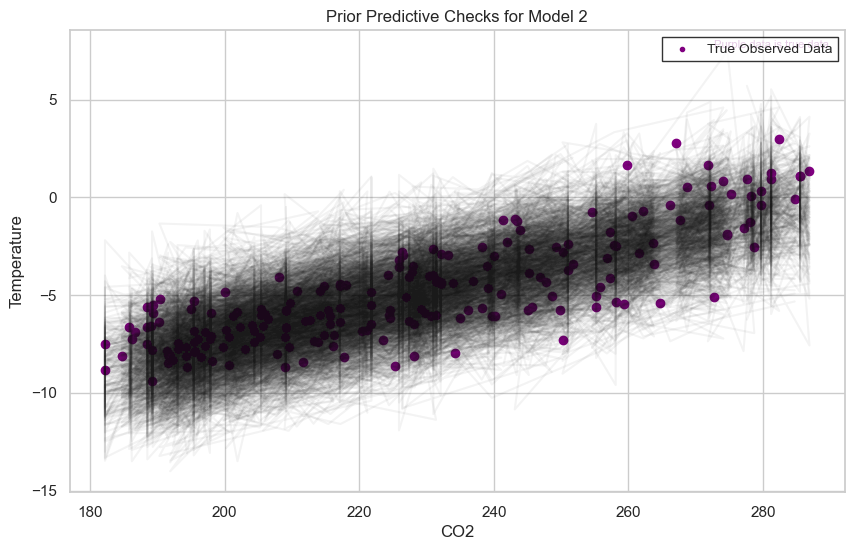

In [27]:
# Prior predictive checks
num_samples = 100

beta_0_prior = norm(loc=-23, scale=1).rvs(num_samples)
beta_1_prior = norm(loc=0.08, scale=1e-3).rvs(num_samples)
sigma_2_prior = gamma(1, data['tmp'].var()/5).rvs(num_samples)
rho_prior = beta(0.1, 1).rvs(num_samples)

# Generate sample using the prior
y_prior = []
for i in range(num_samples):
    theta = [beta_0_prior[i], beta_1_prior[i], sigma_2_prior[i],rho_prior[i]]
    y_prior.append(simulate_mod2(x_obs, theta))

# Plot le prior prédictive checks
plt.figure(figsize=(10, 6))
for yp in y_prior:
    plt.plot(x_obs, yp, color='k', alpha=0.05) # Prior predictive checks
plt.scatter(x_obs, y_obs, color='purple', label='True Observed Data')  # True observed data
plt.title('Prior Predictive Checks for Model 2')
plt.xlabel('CO2')
plt.ylabel('Temperature')
plt.legend(loc='upper right', fontsize='small', markerscale=0.5, frameon=True, edgecolor='black', fancybox=False)
plt.annotate('Purple data is true data', xy=(0.98, 0.98), xycoords='axes fraction', ha='right', va='top', fontsize=8, color='purple')
plt.show()

 When n = 3 we get the relevant statistics (mode, mean, kurtosis, standard deviation and skewness) which are close to those of the true observed temperature. Those gotten when n = 1 or n = 2 are not far away off either.

With model 2 : 

Let's start by defining the full joint probability distribution: 

$P((x,y), \beta_0,\beta_1, \sigma^2, \rho) = p(\rho)\cdot P(\beta_0) \cdot P(\beta_1) \cdot P(\sigma^2) \cdot P((x,y)|\beta_0,\beta_1, \sigma^2)$.

We get interesting relevent statistics which around of those of the true observed temperature like those gotten in the prior predictive 1.

# Compute: Posterior inference

Repeat Q6, Q7 and Q8 for both models.

<div class="alert alert-success">
    
**Q6**. Compute the posterior distribution of all unobserved random variables. 
    
Tips: If you use MCMC, initialize the chain(s) around the MAP estimate.
    
</div>

 For the model 1:  MCMC
The choice of initial values of the parameter have been explained in the answer2.

In [14]:
# Determining the log_prior p(theta)
def log_prior_mod1(theta):
    prior_beta_0 = norm.logpdf(theta[0], loc=-23, scale=1)
    prior_beta_1 = norm.logpdf(theta[1], loc=0.08, scale=1e-3)
    prior_sigma_2 = gamma.logpdf(theta[2],1 ,data['tmp'].var()/3)
    
    return prior_beta_0 + prior_beta_1 + prior_sigma_2

# Determine the log_likelihood
def log_likelihood_mod1(theta, x, y):
    n = len(x)
    mean = theta[0] + theta[1] * x
    covariance = theta[2] * np.eye(n)
    likelihoods = multivariate_normal.logpdf(y, mean=mean, cov=covariance)
    return np.sum(likelihoods)

# Determine MAP estimate 
def map_log_likelihood_mod1(theta, x, y):
    return - log_likelihood_mod1(theta, x, y) - log_prior_mod1(theta)

# Initial value for each parameter
initial1 = [norm(-23.16, 1).rvs(), uniform(0.08, 1e-3).rvs(), gamma(1,data['tmp'].var()/3).rvs()]

# Minimize the map_log_likelihood function
result1 = minimize(map_log_likelihood_mod1, initial1, args=(data['co2'], data['tmp']))
result1

C:\Users\Eto\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Eto\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Eto\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Eto\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 363.9463807996746
 hess_inv: array([[ 6.50276568e-02, -2.23580298e-04, -5.95212976e-03],
       [-2.23580298e-04,  9.82633688e-07,  2.14803813e-05],
       [-5.95212976e-03,  2.14803813e-05,  7.92935773e-02]])
      jac: array([   -1.85908127, -1530.75172806,     3.58635712])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 95
      nit: 4
     njev: 19
   status: 2
  success: False
        x: array([-22.85091932,   0.07898237,   2.48762724])

For the model 1, the posterior probability density function of the parameters $\beta_0$, $\beta_1$ and $\sigma^2$ given the observaed data (x,y):

$$\log(p(\beta_0, \beta_1, \sigma^2| (x, y)) \propto 
\log(p(\beta_0)) + \log(p(\beta_1)) + \log(p(\sigma^2)) + \log(p((x,y) |\beta_0, \beta_1, \sigma^2))$$


In [15]:
# Determining the log_posterior p((x,y)|theta)
def log_posterior_mod1(theta, x, y):
    lp = log_prior_mod1(theta)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood_mod1(theta,x,y) + lp

In [16]:
nwalkers1, ndim1 = 30, len(initial1)
pos1 = result1.x + 0.01 * np.random.randn(nwalkers1, ndim1)

In [17]:
sampler1 = emcee.EnsembleSampler(nwalkers1, ndim1, log_posterior_mod1, args=(data['co2'],data['tmp']))
sampler1.run_mcmc(pos1, 5000 , progress=True);

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]C:\Users\Eto\miniconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [51:41<00:00,  1.61it/s]


For the model 2, the posterior probability density function of the parameters $\beta_0$, $\beta_1$, $\rho$ and $\sigma^2$ given the observaed data (x,y)

$$\log(p(\beta_0, \beta_1, \sigma^2, \rho| (x, y)) \propto 
\log(p(\beta_0)) + \log(p(\beta_1)) + \log(p(\sigma^2)) + \log(p(\rho)) + \log(p((x,y) |\beta_0, \beta_1, \sigma^2, \rho))$$


In [26]:
# Determine the log_prior p(theta)
def log_prior_mod2(theta):
    prior_beta_0 = norm.logpdf(theta[0], loc=-23, scale=1)
    prior_beta_1 = norm.logpdf(theta[1], loc=0.08, scale=1e-3)
    prior_sigma_2 = gamma.logpdf(theta[2],1 ,data['tmp'].var()/5)
    prior_rho = uniform.logpdf(theta[3], -0.990, 1.99)


    return prior_beta_0 + prior_beta_1 + prior_sigma_2 + prior_rho

# Determine the log-likelihood
def log_likelihood_mod2(theta, x, y):
    n = len(x)
    rho = theta[3]

    # Generate correlated Gaussian noise
    cov_matrix = np.array([[rho**abs(i - j) if i != j else 1 for i in range(n)] for j in range(n)])

    # Check and print a warning if rho is outside the range ]-1, 1[
    if not (-1 < rho < 1):
        print("Warning: rho value is outside the range ]-1, 1[.")
    
    # Calculate the log-likelihood
    log_likelihoods = multivariate_normal.logpdf(y, mean=theta[0] + theta[1] * x , cov=theta[2] * np.eye(n))
    
    # Sum the log-probabilities to get the total log-likelihood
    return np.sum(log_likelihoods)

# Determine the MAP estimate
def map_log_likelihood_mod2(theta, x, y):
    return -log_likelihood_mod2(theta, x, y) - log_prior_mod2(theta)

# Initial value for each model parameter
initial2 =  [norm(-23, 1).rvs(), uniform(0.08, 1e-3).rvs(), gamma(1 , data['tmp'].var()/5).rvs(), uniform(-0.99, 1.98).rvs()]

# Minimize the map_log_likelihood function
result2 = minimize(map_log_likelihood_mod2, initial2, args=(data['co2'], data['tmp']))
result2

      fun: 364.645891561707
 hess_inv: array([[ 5.53305063e-02, -1.96123597e-04,  5.27124309e-05,
         0.00000000e+00],
       [-1.96123597e-04,  8.73121771e-07, -1.70997060e-06,
         0.00000000e+00],
       [ 5.27124309e-05, -1.70997060e-06,  4.77879349e-02,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
      jac: array([ 0.00000000e+00, -3.81469727e-06,  3.81469727e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 110
      nit: 10
     njev: 22
   status: 0
  success: True
        x: array([-23.05229439,   0.07997918,   2.27462039,   0.57603732])

In [27]:
# Determining the log_posterior p((x,y)|theta)
def log_posterior_mod2(theta, x, y):
    lp = log_prior_mod2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood_mod2(theta,x,y) + lp

In [28]:
nwalkers2, ndim2 = 30, len(initial2)
pos2 = result2.x + 0.01 * np.random.randn(nwalkers2, ndim2)

In [29]:
sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, log_posterior_mod2, args=(data['co2'],data['tmp']))
sampler2.run_mcmc(pos2, 5000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:47:18<00:00,  1.29s/it]


<div class="alert alert-success">
    
**Q7**. Assess whether your inference results are computationally faithful (check the convergence, mixing, and autocorrelation of the chains).
    
</div>

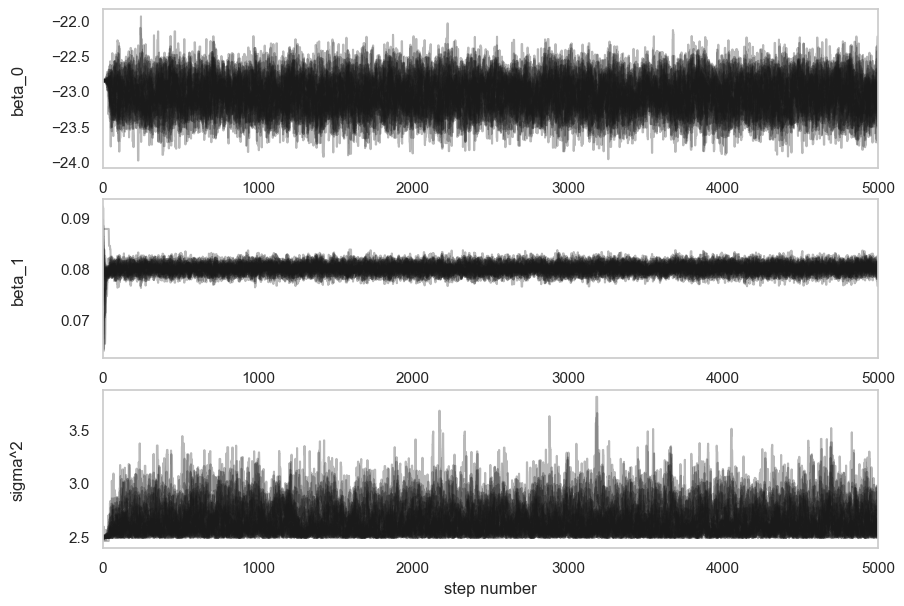

In [18]:
labels1 = ["beta_0", "beta_1", "sigma^2"]

fig, axes = plt.subplots(3, figsize=(10, 7))
thetas1 = sampler1.get_chain()

for i in range(3):
    ax = axes[i]
    ax.plot(thetas1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(thetas1))
    ax.set_ylabel(labels1[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(False)

axes[-1].set_xlabel("step number")
plt.show()

We note that the estimated values of the model parameters of model 1 all cover a precise interval over the iterations: $\beta_0$, $\beta_1$, $\sigma^2$ $\in$ ]-24;-22.2[ x ]0.075;0.09[ x ]2.5;4[ . The chains are stabilized and explore sufficiently good these previous intervals and converge towards the posterior distribution of each parameter. That yields a good mixing. We can visualize them through the trace plots of the chain samples. The autocorrelation times are relatively not high, meaning that the decorrelation time between two consecutive samples of the same dimension is not long. That facilitates the convergence of channels.

In summary, the MCMC algorithm converges quickly after just 1000 iterations, indicating that the consecutive samples generated for each posterior parameter are independent.  Hence posterior parameter estimates are not biased and autocorrelation (correlation between consecutive samples) is reduced.

In [20]:
tau1 = sampler1.get_autocorr_time()
tau1

array([41.18030319, 42.82377708, 49.30577613])

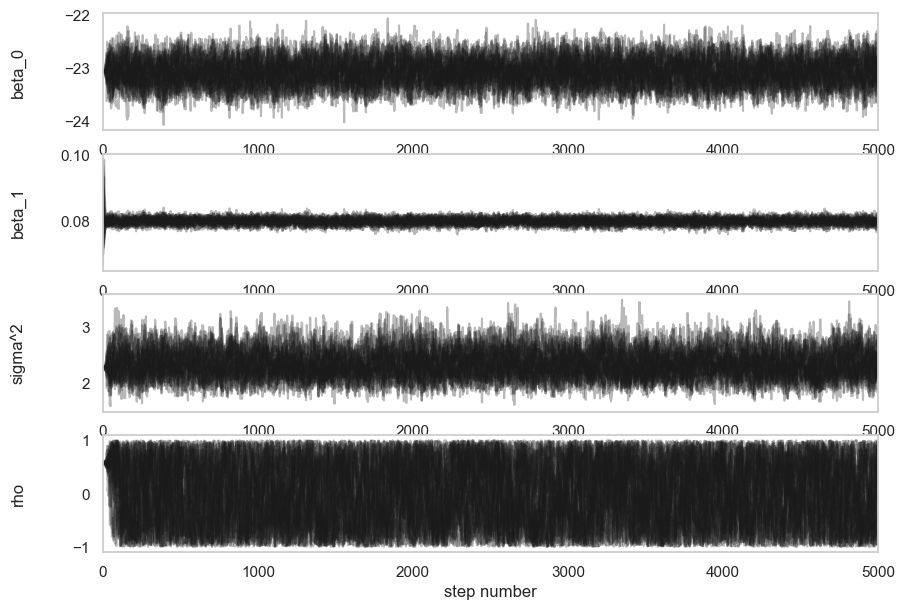

In [30]:
# Model 2: 
labels2 = ["beta_0", "beta_1", "sigma^2","rho"]

fig, axes = plt.subplots(4, figsize=(10, 7))
thetas2 = sampler2.get_chain()

for i in range(4):
    ax = axes[i]
    ax.plot(thetas2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(thetas2))
    ax.set_ylabel(labels2[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(False)

axes[-1].set_xlabel("step number")
plt.show()

We note that the estimated values of the model parameters of model 1 all cover a precise interval over the iterations: $\beta_0$, $\beta_1$, $\sigma^2$, $,$\rho$ $\in$ ]-24;-22.2[ x ]0.07;0.09[ x ]1.8;3.5[ x ]-1;1[ . The chains are stabilized and explore sufficiently good these previous intervals and converge towards the posterior distribution of each parameter. That yields a good mixing. We can visualize them through the trace plots of the chain samples. The autocorrelation times are relatively not high, meaning that the decorrelation time between two consecutive samples of the same dimension is not long. That facilitates the convergence of channels.

In summary, the MCMC algorithm converges quickly after just 1000 iterations, indicating that the consecutive samples generated for each posterior parameter are independent. Hence posterior parameter estimates are not biased and autocorrelation (correlation between consecutive samples) is reduced.

In [32]:
tau2 = sampler2.get_autocorr_time()
tau2

array([48.58261525, 47.84040257, 54.9775446 , 61.15848908])

<div class="alert alert-success">
    
**Q8**. Plot the posterior distributions and discuss the results.
    
</div>

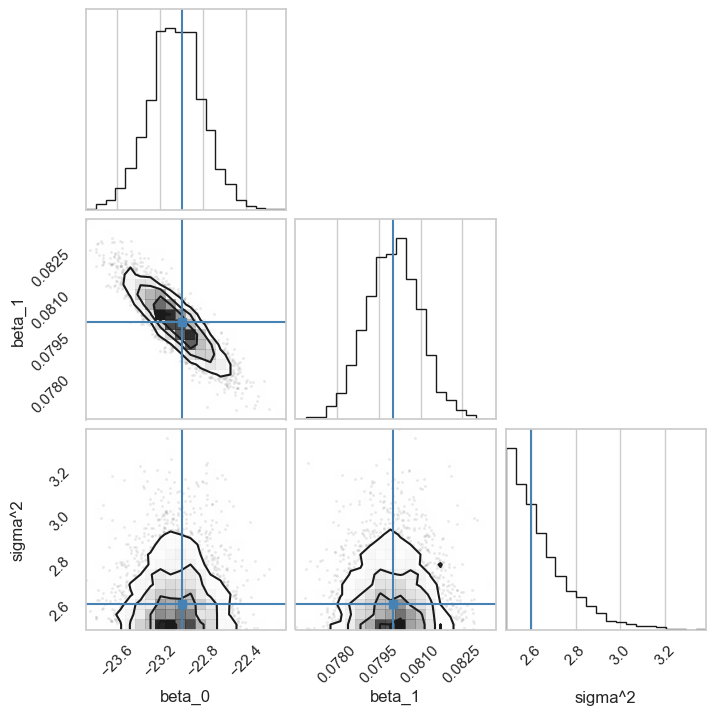

In [19]:
# For the model 1: 
theta_true1 = [-23. ,0.08,2.6]
thetas1 = sampler1.get_chain(flat=True, discard=200, thin=45)
thetas1_ = sampler1.get_chain(flat=True)
fig = corner.corner(thetas1, labels=labels1, truths = theta_true1)

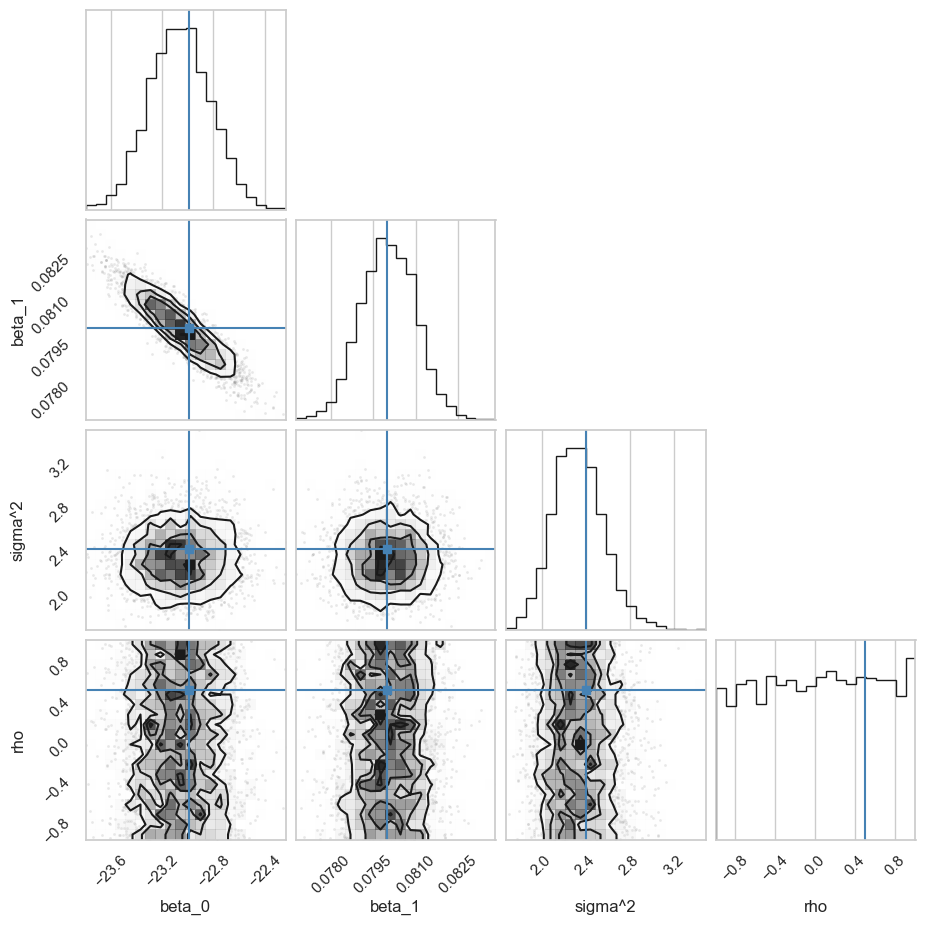

In [31]:
# For the model 2:
theta_true2 = [-22.99 ,0.080,2.4, 0.5]
thetas2 = sampler2.get_chain(flat=True, discard=200, thin=45)
thetas2_ = sampler2.get_chain(flat=True)
fig = corner.corner(thetas2, labels=labels2, truths=theta_true2)

For the both, we obtain almost the same outcomes as follows: 

- The diagonal plots display histograms of each parameter in the chain and the off-diagonal plots display scatter plots between pairs of parameters.

- The mode of the histogram of parameter $\beta_0$ is in the interval [-23.5;-22.5], that of $\beta_1$ is in [0.078; 0.0825] and that of $\sigma^2$ is in [2.6;3.4[. In addition, the darkest regions represent the highest probability densities for each pair of parameters of our models. That helps us to overlay better the true parameters in these regions.

- We add for the model 2, the interval [0.35; 0.4] represneting the most likely region for the parameter $\rho$.

# Criticize

<div class="alert alert-success">
    
**Q9**. Compare the posterior predictive distributions of replicated data $\{y^\text{rep}\}$ for  Model 1 and Model 2. Discuss each in comparison to the distribution of the data measurements.
    
</div>

In [42]:
# Posterior predictive distribution (model 1)

def pp1(x, num, thetas):
    # Permute parameter values
    permuted_indices = np.random.permutation(len(thetas))[:num]

    # Set the estimated posterior distributions
    beta_0_post = thetas[permuted_indices, 0]
    beta_1_post = thetas[permuted_indices, 1] 
    sigma_2_post = thetas[permuted_indices, 2]

    # Simulate temperature samples
    y_samples = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_post[i], beta_1_post[i], sigma_2_post[i]]

        # Simulate temperature samples using the provided simulation function
        y_sample_i = simulate_mod1(x, theta_i)
        y_samples.append(y_sample_i)
           
    return {'y_samples': np.array(y_samples)}

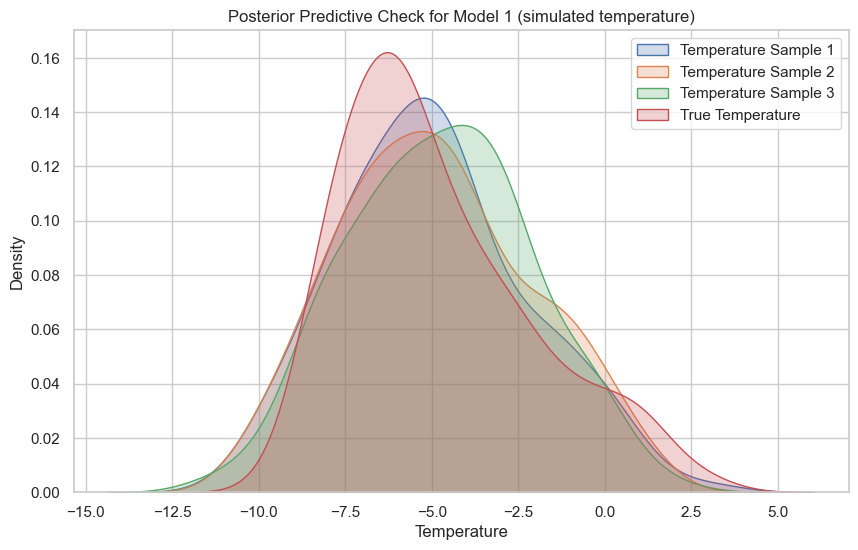

In [45]:
# Visual inspection of the posterior predictive distribution
np.random.seed(1)
simulation_result = pp1(data['co2'], num=3, thetas =thetas1)  

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i, tmp_sample_i in enumerate(simulation_result['y_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Posterior Predictive Check for Model 1 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

In [48]:
# Posterior predictive distribution (model 2)

def pp2(x, num, thetas):
    # Permute parameter values
    permuted_indices = np.random.permutation(len(thetas))[:num]

    # Set the estimated posterior distributions
    beta_0_post = thetas[permuted_indices, 0]
    beta_1_post = thetas[permuted_indices, 1] 
    sigma_2_post = thetas[permuted_indices, 2]
    rho_2_post = thetas[permuted_indices, 3]

    # Simulate temperature samples
    y_samples = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_post[i], beta_1_post[i], sigma_2_post[i], rho_2_post[i]]

        # Simulate temperature samples using the provided simulation function
        y_sample_i = simulate_mod2(x, theta_i)
        y_samples.append(y_sample_i)
           
    return {'y_samples': np.array(y_samples)}

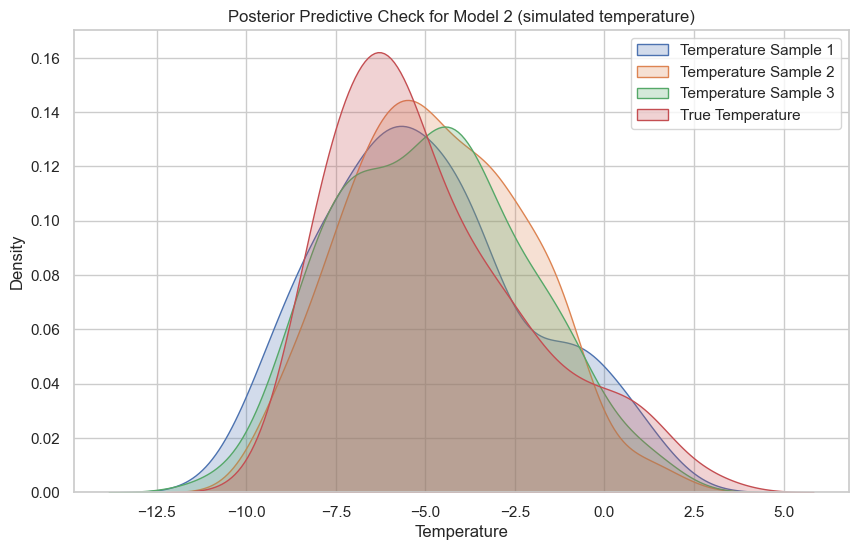

In [47]:
# Visual inspection of the posterior predictive distribution
np.random.seed(1)
simulation_result = pp2(data['co2'], num=3, thetas =thetas2)  

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i, tmp_sample_i in enumerate(simulation_result['y_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Posterior Predictive Check for Model 2 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

In [48]:
def compute_mse(model_func, x, y, num_samples, thetas):
    posterior_samples = model_func(x, num_samples,thetas)['y_samples']
    mse_list = []
    for i in range(num_samples):
        predicted_tmp = posterior_samples[i]  
        mse = mean_squared_error(y, predicted_tmp)
        mse_list.append(mse)
    return mse_list

num = thetas1.shape[0]
# Model 2
mse_model2 = compute_mse(pp1, data['co2'], data['tmp'].values, num, thetas2)
average_mse_model2 = sum(mse_model2) / len(mse_model2)

# Model 1
mse_model1 = compute_mse(pp1, data['co2'], data['tmp'].values, num, thetas1)
average_mse_model1 = sum(mse_model1) / len(mse_model1)

# Print average MSEs
print(f"Average Mean Squared Error for Model 1: {average_mse_model1}")
print(f"Average Mean Squared Error for Model 2: {average_mse_model2}")

# Compare the averages
if average_mse_model1 < average_mse_model2:
    print("Model 1 has lower average MSE, indicating better performance.")
elif average_mse_model1 > average_mse_model2:
    print("Model 2 has lower average MSE, indicating better performance.")
else:
    print("Both models have the same average MSE.")

Average Mean Squared Error for Model 1: 4.979271828516664
Average Mean Squared Error for Model 2: 4.672038406592403
Model 2 has lower average MSE, indicating better performance.


The MSE we calculate represents the $bias^2$ ; the higher it is, the poorer the model. 
According to the previous results, the posterior predictive distributions of replicated data of the model 2 is better than the one of model 1.

<div class="alert alert-success">
    
**Q10**. Compare and discuss the posterior predictive distributions of test quantities of replicated data for Model 1 and Model 2. 
    
</div>

In [34]:
# Mean and standard deviation of the true temperature
print("Empirical mean =", np.mean(data['tmp']))
print("Empirical std =", np.std(data['tmp']))

Empirical mean = -4.84375
Empirical std = 2.7246538197539887


In [39]:
# Posterior predictive distribution (Model 1):
print("Model 1 : E_p(beta_0|x)[beta_0] =", np.mean(thetas1[:, 0]))
print("Model 1 : E_p(beta_1|x)[beta_1] =", np.mean(thetas1[:, 1]))
print("Model 1  : E_p(sigma_2|x)[sigma_2] =", np.mean(thetas1[:, 2]))
print()

# Posterior predictive distribution (Model 2):
print("Model 2 : E_p(beta_0|x)[beta_0] =", np.mean(thetas2[:, 0]))
print("Model 2 : E_p(beta_1|x)[beta_1] =", np.mean(thetas2[:, 1]))
print("Model 2 : E_p(sigma_2|x)[sigma_2] =", np.mean(thetas2[:, 2]))

Model 1 : E_p(beta_0|x)[beta_0] = -23.053560399844407
Model 1 : E_p(beta_1|x)[beta_1] = 0.08000347875969924
Model 1  : E_p(sigma_2|x)[sigma_2] = 2.6407344354124582

Model 2 : E_p(beta_0|x)[beta_0] = -23.06771151060292
Model 2 : E_p(beta_1|x)[beta_1] = 0.08001466595860039
Model 2 : E_p(sigma_2|x)[sigma_2] = 2.33019747967919


In [46]:
for num in range(1,51):
    result = pp1(data['co2'], num=num, thetas=thetas1)
    mean_value = np.mean(result['y_samples'])
    print(f"For num = {num}, Mean of the simulated obtained is: {mean_value} with model 1")

For num = 1, Mean of the simulated obtained is: -5.01155241771948 with model 1
For num = 2, Mean of the simulated obtained is: -4.741110586650749 with model 1
For num = 3, Mean of the simulated obtained is: -4.779196674783372 with model 1
For num = 4, Mean of the simulated obtained is: -4.838821560495953 with model 1
For num = 5, Mean of the simulated obtained is: -4.796808115727732 with model 1
For num = 6, Mean of the simulated obtained is: -4.800112850845331 with model 1
For num = 7, Mean of the simulated obtained is: -4.822495603542363 with model 1
For num = 8, Mean of the simulated obtained is: -4.855776753211104 with model 1
For num = 9, Mean of the simulated obtained is: -4.901341352291185 with model 1
For num = 10, Mean of the simulated obtained is: -4.851098502828275 with model 1
For num = 11, Mean of the simulated obtained is: -4.887063375157863 with model 1
For num = 12, Mean of the simulated obtained is: -4.864429039056313 with model 1
For num = 13, Mean of the simulated ob

In [50]:
for num in range(1,51):
    result = pp2(data['co2'], num=num, thetas=thetas2)
    mean_value = np.mean(result['y_samples'])
    print(f"For num = {num}, Mean of the simulated obtained is: {mean_value} with model 2")

For num = 1, Mean of the simulated obtained is: -4.5297124264017485 with model 2
For num = 2, Mean of the simulated obtained is: -5.080955989071462 with model 2
For num = 3, Mean of the simulated obtained is: -4.824545896278266 with model 2
For num = 4, Mean of the simulated obtained is: -5.007633585520506 with model 2
For num = 5, Mean of the simulated obtained is: -4.938796441721602 with model 2
For num = 6, Mean of the simulated obtained is: -4.906519631360396 with model 2
For num = 7, Mean of the simulated obtained is: -4.921424469713233 with model 2
For num = 8, Mean of the simulated obtained is: -4.74596694221961 with model 2
For num = 9, Mean of the simulated obtained is: -4.84560496466778 with model 2
For num = 10, Mean of the simulated obtained is: -4.8249691808581785 with model 2
For num = 11, Mean of the simulated obtained is: -4.748744245331486 with model 2
For num = 12, Mean of the simulated obtained is: -4.9540619429299815 with model 2
For num = 13, Mean of the simulated 

Typically the mean of simulated data with model 1 or model 2 are close to the thrue mean of data temperature.

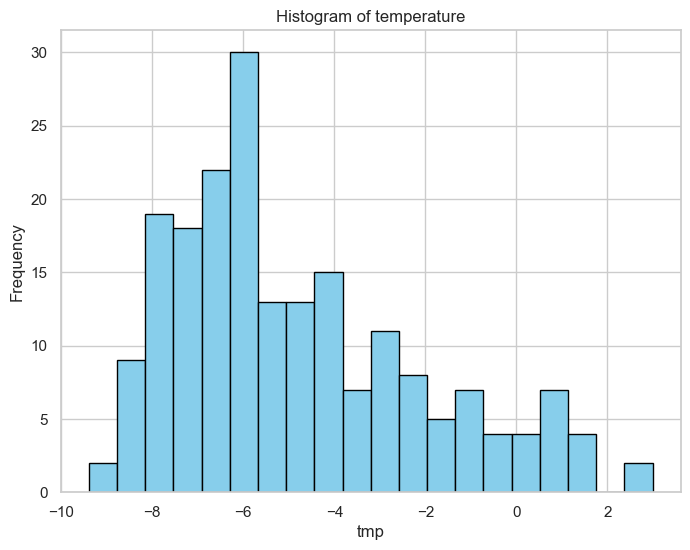

In [52]:
# Visual inspection of the posterior predictive distribution
plt.figure(figsize=(8, 6))
plt.hist(data['tmp'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of temperature')
plt.xlabel('tmp')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

For num = 1, Mean of the simulated obtained is: -4.926082140199154 with model 1
For num = 1, Standard deviation of the simulated obtained is: 2.728903384939783 with model 1

For num = 2, Mean of the simulated obtained is: -4.638409176115072 with model 1
For num = 2, Standard deviation of the simulated obtained is: 2.763913427258125 with model 1

For num = 3, Mean of the simulated obtained is: -4.800621276314962 with model 1
For num = 3, Standard deviation of the simulated obtained is: 2.7991583116318113 with model 1

For num = 4, Mean of the simulated obtained is: -4.817403314365503 with model 1
For num = 4, Standard deviation of the simulated obtained is: 2.729552209716509 with model 1

For num = 5, Mean of the simulated obtained is: -4.78627098001346 with model 1
For num = 5, Standard deviation of the simulated obtained is: 2.768382509327091 with model 1

For num = 6, Mean of the simulated obtained is: -4.913575223866259 with model 1
For num = 6, Standard deviation of the simulated o

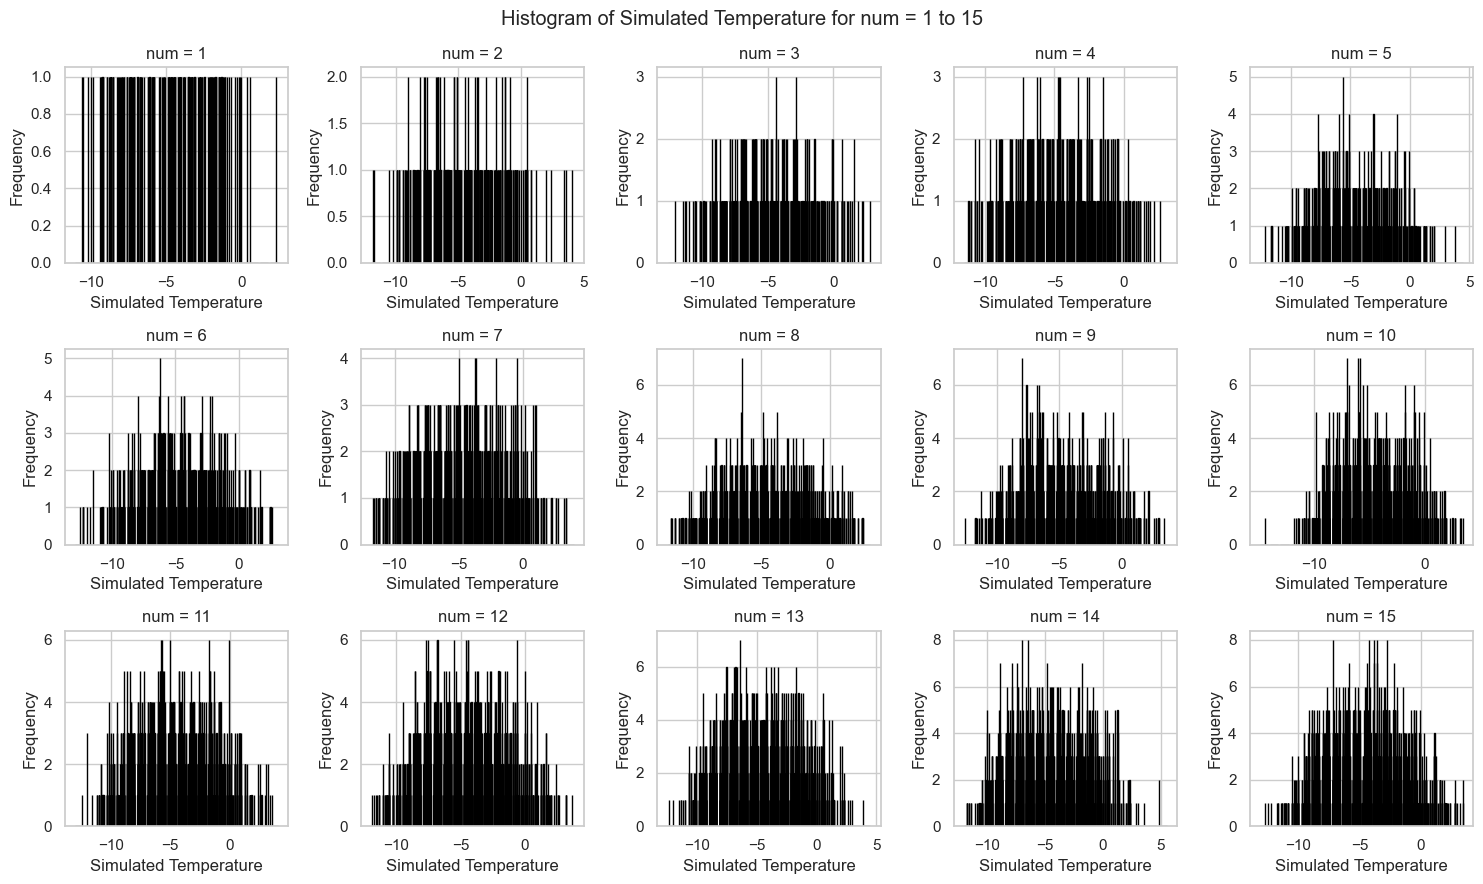

In [59]:
# Create a 3x5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Histogram of Simulated Temperature for num = 1 to 15')

# Counter for tracking the position in the grid
row, col = 0, 0

# Loop through the first 15 num values
for num in range(1, 16):
    # Perform simulation and compute mean
    result = pp1(data['co2'], num=num, thetas=thetas1)
    mean_value = np.mean(result['y_samples'])
    std_value = np.std(result['y_samples'])
    
    # Print mean value
    print(f"For num = {num}, Mean of the simulated obtained is: {mean_value} with model 1")
    print(f"For num = {num}, Standard deviation of the simulated obtained is: {std_value} with model 1")
    print()
    
    # Plot histogram without specifying color
    axes[row, col].hist(result['y_samples'], bins=20, edgecolor='black')
    axes[row, col].set_title(f'num = {num}')
    axes[row, col].set_xlabel('Simulated Temperature')
    axes[row, col].set_ylabel('Frequency')
    
    # Move to the next subplot position
    col += 1
    if col == 5:
        row += 1
        col = 0

# Adjust layout and display plot
plt.tight_layout()
plt.show()

For num = 1, Mean of the simulated obtained is: -4.878587120677018 with model 2
For num = 1, Standard deviation of the simulated obtained is: 2.613749517408944 with model 2

For num = 2, Mean of the simulated obtained is: -4.9227860102349315 with model 2
For num = 2, Standard deviation of the simulated obtained is: 2.6165377508762875 with model 2

For num = 3, Mean of the simulated obtained is: -4.850748551645839 with model 2
For num = 3, Standard deviation of the simulated obtained is: 2.6628940493971043 with model 2

For num = 4, Mean of the simulated obtained is: -4.821541081575342 with model 2
For num = 4, Standard deviation of the simulated obtained is: 2.87019003887022 with model 2

For num = 5, Mean of the simulated obtained is: -5.071390594621404 with model 2
For num = 5, Standard deviation of the simulated obtained is: 2.7129221745068466 with model 2

For num = 6, Mean of the simulated obtained is: -4.942062398717503 with model 2
For num = 6, Standard deviation of the simulate

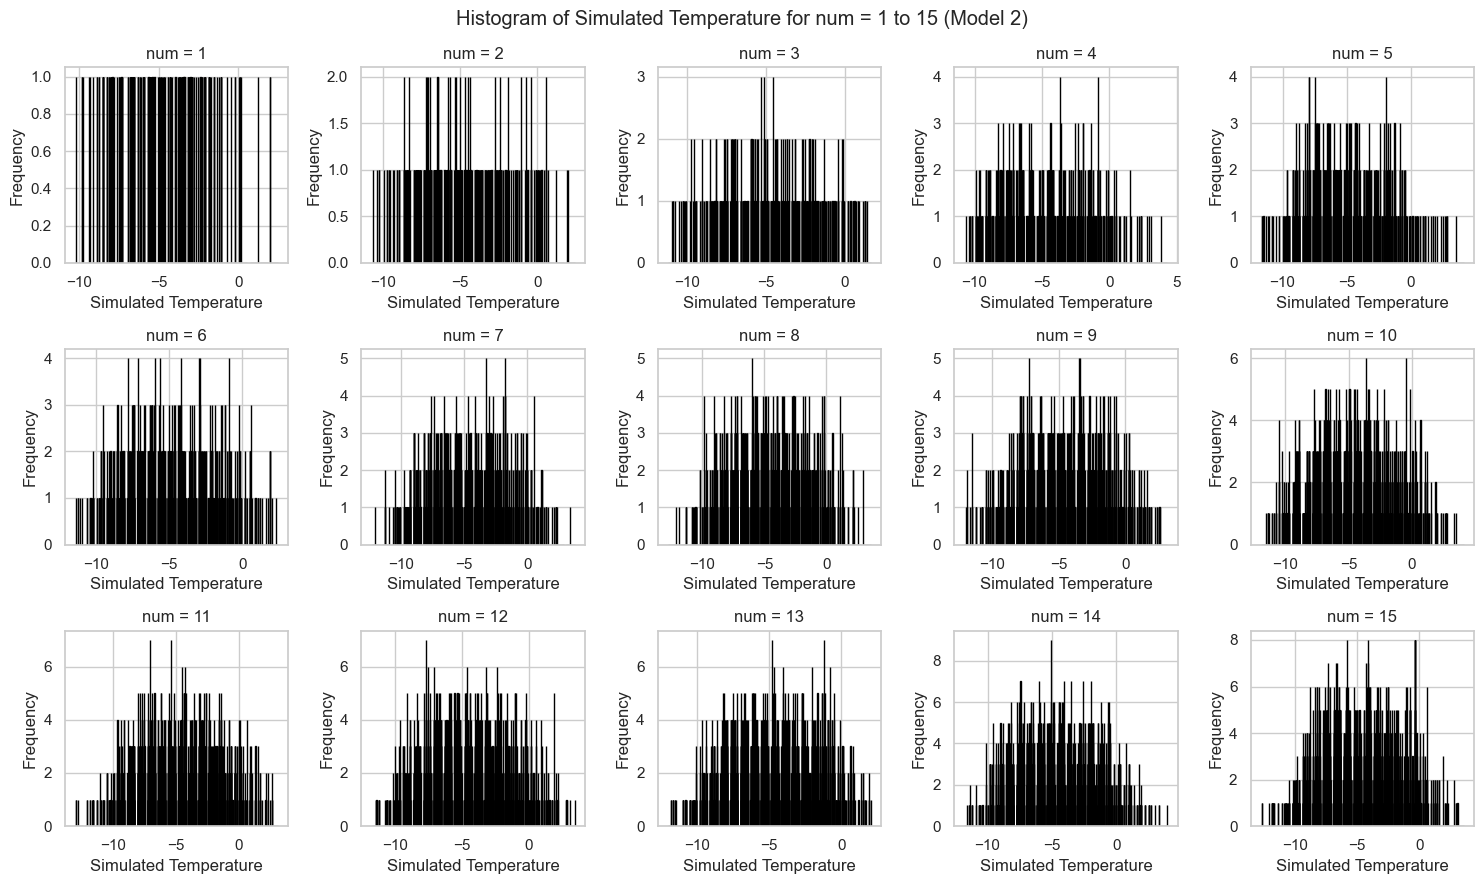

In [60]:
# Create a 3x5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Histogram of Simulated Temperature for num = 1 to 15 (Model 2)')

# Counter for tracking the position in the grid
row, col = 0, 0

# Loop through the first 15 num values
for num in range(1, 16):
    # Perform simulation and compute mean
    result = pp2(data['co2'], num=num, thetas=thetas2)
    mean_value = np.mean(result['y_samples'])
    std_value = np.std(result['y_samples'])
    
    # Print mean value
    print(f"For num = {num}, Mean of the simulated obtained is: {mean_value} with model 2")
    print(f"For num = {num}, Standard deviation of the simulated obtained is: {std_value} with model 2")
    print()

    # Plot histogram without specifying color
    axes[row, col].hist(result['y_samples'], bins=20, edgecolor='black')
    axes[row, col].set_title(f'num = {num}')
    axes[row, col].set_xlabel('Simulated Temperature')
    axes[row, col].set_ylabel('Frequency')
    
    # Move to the next subplot position
    col += 1
    if col == 5:
        row += 1
        col = 0

# Adjust layout and display plot
plt.tight_layout()
plt.show()

Although the histograms of simulated temperatures with models 1 and 2 seem to resemble those of real temperatures in some cases, here are the observations we have made:

- first of all, we notice that the first two histograms of simulated temperatures (num =1) with models 1 and 2 are completely different from those of the true temperatures;

- another general observation is that these histograms appear to be symmetrical, whereas the histogram of the true temperatures is asymmetrical; 

- their tails are generally heavier than those of the true temperatures; 
typically the mean and the temperature of the simulated temperature are close to those of true temperature;

- finally, the frequency associated with the modes of the histograms of the simulated data is in the [20%; 80%] range, whereas the mode of that of the true temperatures is 30%.

<div class="alert alert-success">
    
**Q11**. Evaluate the posterior predictive performance of Model 1 and Model 2.

</div>

In [49]:
# The expected log predictive density
def elpd1(xs, thetas):
    x = xs['co2']  
    y = xs['tmp']
    return np.mean([log_posterior_mod1(theta, x, y) for theta in thetas])

In [50]:
from sklearn.model_selection import KFold
# Define the number of splits
n_splits = 5

# Initialize KFold without shuffling
kf = KFold(n_splits=n_splits, shuffle=False)

elpd_test1 = []

for train_idx, test_idx in kf.split(data):
    # posterior fit
    nwalkers1, ndim1 = 30, len(initial1)
    pos1 = result1.x + 0.001 * np.random.randn(nwalkers1, ndim1)
    sampler1 = emcee.EnsembleSampler(nwalkers1, ndim1, log_posterior_mod1, args=(data['co2'], data['tmp']))
    sampler1.run_mcmc(pos1, 5000, progress=True)
    thetas1 = sampler1.get_chain(flat=True)
    
    # elpd
    subset = np.random.permutation(len(thetas1))[:500]
    elpd_test1.append(elpd1(data.iloc[test_idx], thetas1[subset]))  

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]C:\Users\Eto\miniconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [33:34<00:00,  2.48it/s]


In [51]:
elpd_test1

[-68.07183045761462,
 -75.90645815916652,
 -70.09247946237794,
 -68.66187559795868,
 -64.81281862334141]

In [52]:
np.mean(elpd_test1), np.std(elpd_test1)

(-69.50909246009182, 3.6360724609701536)

In [53]:
# The expected log predictive density
def elpd2(xs, thetas):
    x = xs['co2']  
    y = xs['tmp']
    return np.mean([log_posterior_mod2(theta, x, y) for theta in thetas])

In [54]:
# Initialize an empty list to store the elpd values
elpd_test2 = []

# Apply 5-cross-validation without shuffling the data
for train_idx, test_idx in kf.split(data):
    # posterior fit
    nwalkers2, ndim2 = 30, len(initial2)
    pos2 = result2.x + 0.001 * np.random.randn(nwalkers2, ndim2)
    sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, log_posterior_mod2, args=(data['co2'], data['tmp']))
    sampler2.run_mcmc(pos2, 5000, progress=True)
    thetas2 = sampler2.get_chain(flat=True)
    
    # epld
    subset = np.random.permutation(len(thetas2))[:500]
    elpd_test2.append(elpd2(data.iloc[test_idx], thetas2[subset])) 

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:02:50<00:00,  1.33it/s]


In [55]:
elpd_test2

[-69.17264160068355,
 -78.0896470417959,
 -71.46716025626726,
 -69.8428776380813,
 -65.33456928059053]

In [56]:
np.mean(elpd_test2), np.std(elpd_test2)

(-70.7813791634837, 4.171753459827626)

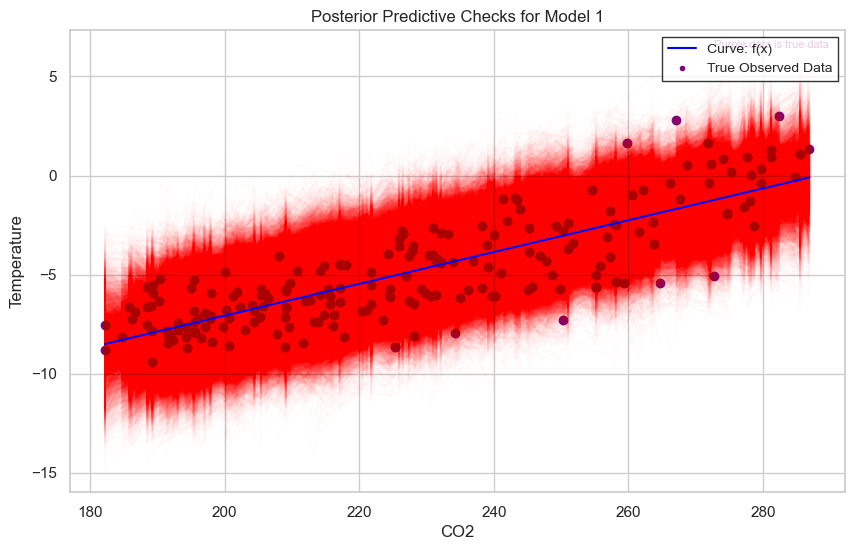

In [25]:
# With a model 1:
# Generate sample using the posterior
y_posterior = []
for theta in thetas1_:
    y_posterior.append(simulate_mod1(x_obs, theta))

# Plot the posterior predictive checks
plt.figure(figsize=(10, 6))
for yp in y_posterior:
    plt.plot(x_obs, yp, color='red', alpha=0.01)  # Adjusted alpha value for visibility
    
x_values = np.linspace(min(x_obs), max(x_obs), 100)
y_values = correlation_coefficient * x_values + (-correlation_coefficient * x_obs.mean() + y_obs.mean())
plt.plot(x_values, y_values, color='blue', label='Curve: f(x)')  # Use plt.plot instead of ax.plot

plt.scatter(x_obs, y_obs, color='purple', label='True Observed Data')  # True observed data
plt.title('Posterior Predictive Checks for Model 1')
plt.xlabel('CO2')
plt.ylabel('Temperature')
plt.legend(loc='upper right', fontsize='small', markerscale=0.5, frameon=True, edgecolor='black', fancybox=False)
plt.annotate('Purple data is true data', xy=(0.98, 0.98), xycoords='axes fraction', ha='right', va='top', fontsize=8, color='purple')
plt.show()

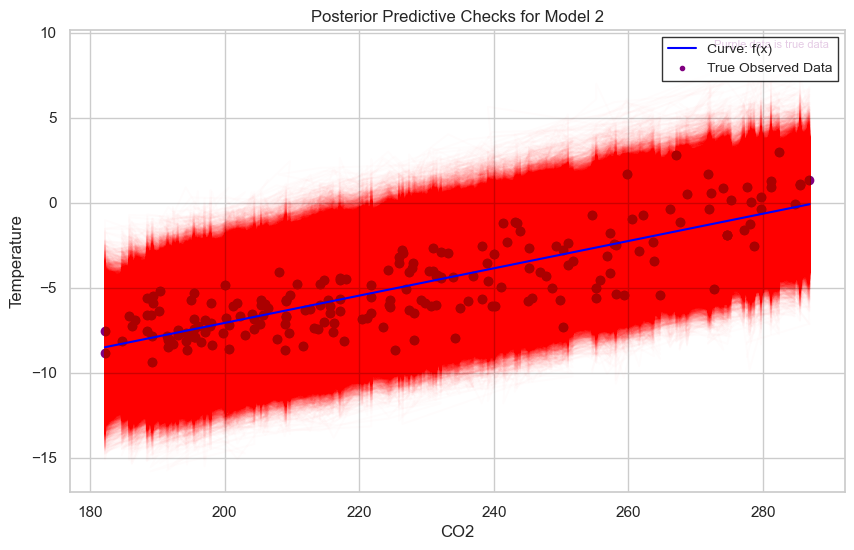

In [33]:
# With a model 2:
# Generate sample using the posterior
y_posterior = []
for theta in thetas2_:
    y_posterior.append(simulate_mod2(x_obs, theta))

# Plot the posterior predictive checks
plt.figure(figsize=(10, 6))
for yp in y_posterior:
    plt.plot(x_obs, yp, color='red', alpha=0.01)  # Adjusted alpha value for visibility
    
x_values = np.linspace(min(x_obs), max(x_obs), 100)
y_values = correlation_coefficient * x_values + (-correlation_coefficient * x_obs.mean() + y_obs.mean())
plt.plot(x_values, y_values, color='blue', label='Curve: f(x)')  # Use plt.plot instead of ax.plot

plt.scatter(x_obs, y_obs, color='purple', label='True Observed Data')  # True observed data
plt.title('Posterior Predictive Checks for Model 2')
plt.xlabel('CO2')
plt.ylabel('Temperature')
plt.legend(loc='upper right', fontsize='small', markerscale=0.5, frameon=True, edgecolor='black', fancybox=False)
plt.annotate('Purple data is true data', xy=(0.98, 0.98), xycoords='axes fraction', ha='right', va='top', fontsize=8, color='purple')
plt.show()

Generation of posterior predictive checks for models 1 and 2 from posterior parameter values in the both previous plots. There are still some observations (6 observations) that the model 1 is not able to predict. 

Applying 5-Cross-validation: 

The mean elpd of model 2 is higher than that of model 1, it suggests that model 2 has better predictive performance on average across the cross-validation folds.
Similarly, if the standard deviation of elpd values for model 2 is lower than that of model 1, it indicates that model 2's performance is more consistent across different folds.

# Revise

<div class="alert alert-success">
    
**Q12**. Explain and motivate what could be tried to further improve the probabilistic models considered in this study. (No implementation is required.)

</div>

Since we observe a slight difference in terms of modes, tails (particularly those of replicated data less important than those of real data) between replicated data and real temperature data:

- first we alter again the prior distibutions of the parameters and check out their relevances through the prior predictive checks;

- use the MCMC in order to determine the posterior distribution of the parameters of each model;

- check out their autocorrelation, mixing and convergence again while ensuring faster convergence towards the posterior distribution and also whether the mixing is good; 

- apply the posterior predictive check for verifying if the $bias^2$ obtained right now are better than the previous results and checking the new predictive performances through the 5-cross validation.